# MAIS202 Final Project
The aim of this project is for doctors to input a couple of numbers related to the patient and the aim is to predict if the patient has a heart disease (Stage 1,2,3, or 4) or not. The Dataset used is a Dataset from UCI and can be found through the following link:
https://www.kaggle.com/redwankarimsony/heart-disease-data

## Importing the required libraries:

In [1]:
from scipy import stats
import pandas as pd
import numpy as np
from sklearn import preprocessing
from sklearn.model_selection import train_test_split
import seaborn as sn
import matplotlib.pyplot as plt
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn import metrics

## Reading the data:

In [2]:
df = pd.read_csv("heart_disease_uci.csv")
df

,id,age,sex,dataset,cp,trestbps,chol,fbs,restecg,thalch,exang,oldpeak,slope,ca,thal,num
0,1,63,Male,Cleveland,typical angina,145.0,233.0,True,lv hypertrophy,150.0,False,2.3,downsloping,0.0,fixed defect,0
1,2,67,Male,Cleveland,asymptomatic,160.0,286.0,False,lv hypertrophy,108.0,True,1.5,flat,3.0,normal,2
2,3,67,Male,Cleveland,asymptomatic,120.0,229.0,False,lv hypertrophy,129.0,True,2.6,flat,2.0,reversable defect,1
3,4,37,Male,Cleveland,non-anginal,130.0,250.0,False,normal,187.0,False,3.5,downsloping,0.0,normal,0
4,5,41,Female,Cleveland,atypical angina,130.0,204.0,False,lv hypertrophy,172.0,False,1.4,upsloping,0.0,normal,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
915,916,54,Female,VA Long Beach,asymptomatic,127.0,333.0,True,st-t abnormality,154.0,False,0.0,NaN,NaN,NaN,1
916,917,62,Male,VA Long Beach,typical angina,NaN,139.0,False,st-t abnormality,NaN,NaN,NaN,NaN,NaN,NaN,0
917,918,55,Male,VA Long Beach,asymptomatic,122.0,223.0,True,st-t abnormality,100.0,False,0.0,NaN,NaN,fixed defect,2
918,919,58,Male,VA Long Beach,asymptomatic,NaN,385.0,True,lv hypertrophy,NaN,NaN,NaN,NaN,NaN,NaN,0


# 1. Pre-Proccessing the data:
In the Pre-Proccessing, I start by dropping the id and datasets columns as they are not beneficial to the final result and will just add un-needed noise to the data if add. I will also remove the thal column as 53% of entries in this column are NaN, which means that having this data may not always be possible, thus it is best to remove it from our dataset.
I also do some conversions in which columns that have boolean data are converted to 0 and 1, and the sex column has been converted to represent a 1 = Male and a 0 = Female. Thus, for those columns, data that is read as strings is now converted to an int to be able to work with.

In [3]:
df = df.drop("id", axis = 1)
df = df.drop("dataset", axis = 1)
df = df.drop("thal", axis = 1)
df["exang"] = df["exang"].apply(lambda x: 1 if (x) else 0)
df["fbs"] = df["fbs"].apply(lambda x: 1 if (x) else 0)
df["sex"] = df["sex"].apply(lambda x: 1 if (x == "Male") else 0)

I now do some data cleaning in which I remove all the rows that have missing values. I also one hot encode the restecg column, in order to convert the categorical data into binary data to be able to work with.

#### The Slope and Ca columns:
The Slope and Ca columns both have 35% of their data to be missing, thus I want to evaluate the correlation between those columns and the final prediction to see if it is best to keep them or discard them from our result. I start by one hot encoding them to convert all of the categorical features into binary values to be able to evaluate them

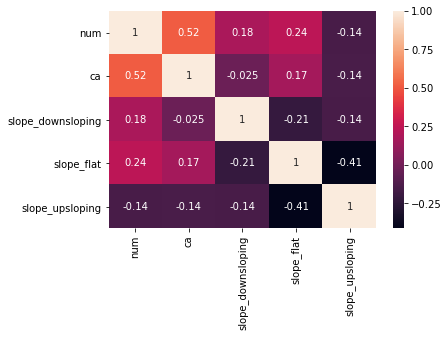

In [4]:
df1 = df[["num","ca","slope"]]
encoded = pd.get_dummies(df1, columns = ["slope"])
corrMatrix = encoded.corr()
sn.heatmap(corrMatrix, annot=True)
plt.show()


Looking at the correlation matrix, it is clear to see that for the Slope column, the data either shows a weak positive or negative correlation with the data. However, for the CA column, it is clear to see that it has a well established positive correlation with the prediction, thus it is better to keep this column. I will now attempt to fill the empty rows by replacing the missing values by replacing them with the average ca value for each disease stage.

In [5]:
clean = df1[df1["ca"].notna()]
averages = []
for i in range(0,5):
    stage = clean.loc[(df["num"] == i)]
    avg_stage = np.mean(stage["ca"])
    averages.append(avg_stage)
for i in range(df1.shape[0]):
    if (str(df1.iloc[i,1]) == "nan"):
        index = df1.iloc[i,0]
        df1.at[i,"ca"] = averages[index]
df1

,num,ca,slope
0,0,0.000000,downsloping
1,2,3.000000,flat
2,1,2.000000,flat
3,0,0.000000,downsloping
4,0,0.000000,upsloping
...,...,...,...
915,1,0.741379,NaN
916,0,0.278788,NaN
917,2,1.222222,NaN
918,0,0.278788,NaN


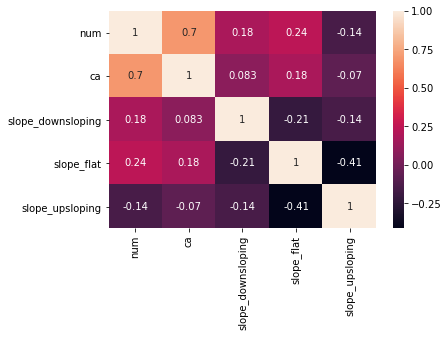

In [6]:
encoded = pd.get_dummies(df1, columns = ["slope"])
corrMatrix = encoded.corr()
sn.heatmap(corrMatrix, annot=True)
plt.show()

Now I will do the same step with the slope column, but this time by taking the mode of the slope value for each disease stage as the slope column is categorical and not numerical.

In [7]:
clean = df1[df1["slope"].notna()]
averages = []
for i in range(0,5):
    stage = clean.loc[(df1["num"] == i)]
    avg_stage = stats.mode(stage["slope"])
    averages.append(avg_stage)
for i in range(df1.shape[0]):
    if (str(df1.iloc[i,2]) == "nan"):
        index = df1.iloc[i,0]
        df1.at[i,"slope"] = averages[index][0][0] 

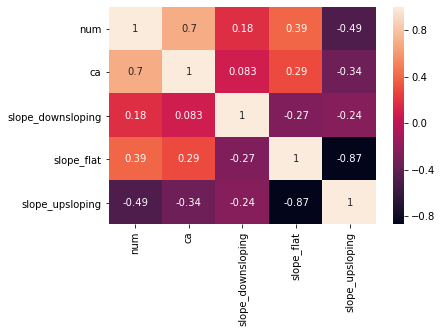

In [8]:
encoded = pd.get_dummies(df1, columns = ["slope"])
corrMatrix = encoded.corr()
sn.heatmap(corrMatrix, annot=True)
plt.show()

Thus it is clear to see that filling in the missing data has made the positive correlation between the prediction and the ca to be a bit stronger, and the correlation between the slopes and the results have not really changed except for the unsloping one. Thus, filling in the data while keeping consistency of correlation the same is a very good step to imporve the accuracy of the model. Now I will go ahead and join the new ca and slope columns with the dataframe. I will preview the befre and after effect that this step had on the accuracy of the test set with the following models:

Decision Tree : 48.3% ---> 81.1%

Random Forest Classifier: 57.5% ---> 79.2%

In [9]:
for i in range(df.shape[0]):
    df.at[i,"ca"] = df1.at[i,"ca"]
    df.at[i,"slope"] = df1.at[i,"slope"]

Now I remove all of the other rows that have missing values and I apply one hot encoding on the rows that have categorical data in order to convert them to binary data ready to be used

In [10]:
for col in list(df.columns.values):
    df = df[df[col].notna()]
encoded_data = pd.get_dummies(df, columns= ["restecg","cp","slope"])
encoded_data

,age,sex,trestbps,chol,fbs,thalch,exang,oldpeak,ca,num,restecg_lv hypertrophy,restecg_normal,restecg_st-t abnormality,cp_asymptomatic,cp_atypical angina,cp_non-anginal,cp_typical angina,slope_downsloping,slope_flat,slope_upsloping
0,63,1,145.0,233.0,1,150.0,0,2.3,0.000000,0,1,0,0,0,0,0,1,1,0,0
1,67,1,160.0,286.0,0,108.0,1,1.5,3.000000,2,1,0,0,1,0,0,0,0,1,0
2,67,1,120.0,229.0,0,129.0,1,2.6,2.000000,1,1,0,0,1,0,0,0,0,1,0
3,37,1,130.0,250.0,0,187.0,0,3.5,0.000000,0,0,1,0,0,0,1,0,1,0,0
4,41,0,130.0,204.0,0,172.0,0,1.4,0.000000,0,1,0,0,0,1,0,0,0,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
913,62,1,158.0,170.0,0,138.0,1,0.0,0.741379,1,0,0,1,1,0,0,0,0,1,0
914,46,1,134.0,310.0,0,126.0,0,0.0,1.222222,2,0,1,0,1,0,0,0,0,1,0
915,54,0,127.0,333.0,1,154.0,0,0.0,0.741379,1,0,0,1,1,0,0,0,0,1,0
917,55,1,122.0,223.0,1,100.0,0,0.0,1.222222,2,0,0,1,1,0,0,0,0,1,0


In [ ]:
encoded_data.to_csv('train.csv', index=False)

# 2. Machine Learning:
## Hyper-Parameter Tuning:
Now I will start by performing 5 fold cross validation in order to find the best hyper-parameters for the decision tree. The hyper-parameters to be tuned are max depth and max_features

In [11]:
def five_fold_split(data):
  (rows, columns) = data.shape
  split_ratio = (rows//5)
  part1 = data.iloc[:split_ratio, :]
  part2 = data.iloc[split_ratio:split_ratio*2, :]
  part3 = data.iloc[split_ratio*2:split_ratio*3, :]
  part4 = data.iloc[split_ratio*3:split_ratio*4, :]
  part5 = data.iloc[split_ratio*4:, :]
  return part1,part2,part3,part4,part5

In [12]:
def cross_val_DecisionTree(data,depth,features):
  (part1,part2,part3,part4,part5) = five_fold_split(data)
  tree = DecisionTreeClassifier(max_depth = depth, max_features= features)
  predictions = []
  for i in range(5):
    parts = [part1,part2,part3,part4,part5]
    val = parts[i]
    valX = val.drop("num",axis = 1)
    valY = val["num"]
    parts.pop(i)
    trainingMerge = pd.concat(parts)
    trainY = trainingMerge["num"]
    trainX = trainingMerge.drop("num",axis = 1)
    tree.fit(trainX, trainY.values.ravel())
    prediction = tree.predict(valX)
    accuracy= metrics.accuracy_score(valY,prediction)
    predictions.append(accuracy)
  return (np.mean(predictions))

val = []
bestV = [0,0,0]
 #creating decision trees for values of max_depth from 1 to 30 and max_features 1 to 20
for depth in range(1,31):
  for features in range(1,20):
    v = cross_val_DecisionTree(encoded_data, depth, features)
    resV = [depth,features,v]
    val.append(resV)
    if (resV[2] > bestV[2]):
        bestV = resV
print(bestV)

[6, 19, 0.8181818181818181]


### The result above shows that the maximum accuracy can be achieved by having the hyperparamters for the Decision Tree be a max depth of 5 and a max features of 16. Those hyperparameters result in a maximum validation accuracy of 82.3%

In [13]:
def cross_val_RandomForest(data,depth,features,n_estimators):
  (part1,part2,part3,part4,part5) = five_fold_split(data)
  tree = RandomForestClassifier(max_depth = depth, max_features= features, n_estimators = n_estimators)
  predictions = []
  for i in range(5):
    parts = [part1,part2,part3,part4,part5]
    val = parts[i]
    valX = val.drop("num",axis = 1)
    valY = val["num"]
    parts.pop(i)
    trainingMerge = pd.concat(parts)
    trainY = trainingMerge["num"]
    trainX = trainingMerge.drop("num",axis = 1)
    tree.fit(trainX, trainY.values.ravel())
    prediction = tree.predict(valX)
    accuracy= metrics.accuracy_score(valY,prediction)
    predictions.append(accuracy)
  return (np.mean(predictions))

val = []
bestV = [0,0,0,0]
 #creating decision trees for values of max_depth from 1 to 30 and max_features 1 to 20
for estimators in [50,100,150]:
    print(estimators)
    for depth in range(1,31):
      for features in range(1, 20):
        v = cross_val_RandomForest(encoded_data, depth, features,estimators)
        resV = [depth,features,estimators,v]
        val.append(resV)
        if (resV[3] > bestV[3]):
            bestV = resV
print(bestV)

50
100
150
[6, 18, 50, 0.8472727272727273]


### The result above shows that the maximum accuracy can be achieved by having the hyperparamters for the Random Forest be a max depth of 5, a max features of 16, and a n estimators of 50. Those hyperparameters result in a maximum validation accuracy of 83.4%

In [155]:
X_data = encoded_data.drop("num",axis = 1)
Y_data = encoded_data["num"]
X_train, X_test, Y_train, Y_test = train_test_split(X_data, Y_data, test_size = 0.2)
tree = []
forest = []
for i in range(0,20):
#    model = DecisionTreeClassifier(max_depth = 5, max_features= 10)
    model = DecisionTreeClassifier(max_depth = 6, max_features= 19)
    model.fit(X_train,Y_train)
    test = model.predict(X_test)
    resTest = metrics.accuracy_score(Y_test, test)
    train = model.predict(X_train)
    resTrain = metrics.accuracy_score(Y_train, train)
    tree.append(resTest)
    #print("------------------Decision Tree Classifier-----------------------------")
    #print(f"Train accuracy is {resTrain}")
    #print(f"Test accuracy is {resTest}")
    model = RandomForestClassifier(max_depth = 6, max_features= 19, n_estimators = 150 )
    #model = RandomForestClassifier(max_depth = 6, max_features= 18, n_estimators = 50 )
    model.fit(X_train,Y_train)
    test = model.predict(X_test)
    resTest = metrics.accuracy_score(Y_test, test)
    train = model.predict(X_train)
    resTrain = metrics.accuracy_score(Y_train, train)
    forest.append(resTest)
    #print("------------------Random Forest Classifier-----------------------------")
    #print(f"Train accuracy is {resTrain}")
    #print(f"Test accuracy is {resTest}")
print("------------------Random Forest Classifier-----------------------------")
print(f"Test accuracy is {np.mean(forest)}")
print("------------------Decision Tree Classifier-----------------------------")
print(f"Test accuracy is {np.mean(tree)}")

------------------Random Forest Classifier-----------------------------
Test accuracy is 0.832121212121212
------------------Decision Tree Classifier-----------------------------
Test accuracy is 0.8103030303030303


## Applying Bagging on both models to decrease the variance and improve accuracy

In [167]:
def five_fold_splitY(data):
  rows = len(data)
  split_ratio = (rows//5)
  part1 = data.iloc[:split_ratio]
  part2 = data.iloc[split_ratio:split_ratio*2]
  part3 = data.iloc[split_ratio*2:split_ratio*3]
  part4 = data.iloc[split_ratio*3:split_ratio*4]
  part5 = data.iloc[split_ratio*4:]
  return part1,part2,part3,part4,part5

def Decision_Tree_bagging(X_train,Y_train,X_test,Y_test):
    (part1,part2,part3,part4,part5) = five_fold_split(X_train)
    X_parts = [part1,part2,part3,part4,part5]
    (part1,part2,part3,part4,part5) = five_fold_splitY(Y_train)
    Y_parts = [part1,part2,part3,part4,part5]
    predictions = []
    Z = []
    predictions = []
    for i in range(0,5):

        #model = DecisionTreeClassifier(max_depth = 5, max_features= 10)
        model = DecisionTreeClassifier(max_depth = 6, max_features= 19)
        model.fit(X_parts[i],Y_parts[i])
        test = model.predict(X_test)
        predictions.append(test)
    averages = []
    for j in range(0,len(Y_test)):
        predicted = []
        for z in range(5):
            predicted.append(predictions[z][j])
        averages.append(stats.mode(predicted)[0][0])
    return averages

def Random_Forest_bagging(X_train,Y_train,X_test,Y_test):
    (part1,part2,part3,part4,part5) = five_fold_split(X_train)
    X_parts = [part1,part2,part3,part4,part5]
    (part1,part2,part3,part4,part5) = five_fold_splitY(Y_train)
    Y_parts = [part1,part2,part3,part4,part5]
    predictions = []
    Z1 = []
    predictions = []
    for i in range(0,5):
        model = RandomForestClassifier(max_depth = 6, n_estimators = 150, max_features= 14 )
        #model = RandomForestClassifier(max_depth = 6, max_features= 18, n_estimators = 50 )
        model.fit(X_parts[i],Y_parts[i])
        test = model.predict(X_test)
        predictions.append(test)
    averages = []
    for j in range(0,len(Y_test)):
        predicted = []
        for z in range(5):
            predicted.append(predictions[z][j])
        averages.append(stats.mode(predicted)[0][0])
    #accuracy = metrics.accuracy_score(Y_test, averages)
    return averages

In [157]:
Z = []
Z1 = []
for e in range(0,20):
    accuracy = metrics.accuracy_score(Y_test,Decision_Tree_bagging(X_train,Y_train,X_test,Y_test))
    Z.append(accuracy)
    accuracy = metrics.accuracy_score(Y_test, Random_Forest_bagging(X_train,Y_train,X_test,Y_test))
    Z1.append(accuracy)
    
print("------------------Random Forest Classifier-----------------------------")    
print(f"Test accuracy is {np.mean(Z1)}")    
print("------------------Decision Tree Classifier-----------------------------")
print(f"Test accuracy is {np.mean(Z)}")

------------------Random Forest Classifier-----------------------------
Test accuracy is 0.8145454545454547
------------------Decision Tree Classifier-----------------------------
Test accuracy is 0.789090909090909


## Graphing the Results

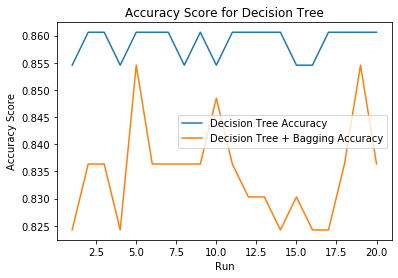

In [25]:
#plt.plot(range(1,11),forest, label="Random Forest Accuracy")
plt.plot(range(1,21),tree, label = "Decision Tree Accuracy")
#plt.plot(range(1,11),Z1, label="Random Forest + Bagging Accuracy")
plt.plot(range(1,21),Z, label = "Decision Tree + Bagging Accuracy")
plt.legend()
plt.xlabel("Run")
plt.ylabel("Accuracy Score")
plt.title("Accuracy Score for Decision Tree")
plt.show()

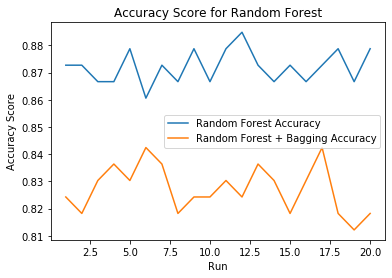

In [26]:
plt.plot(range(1,21),forest, label="Random Forest Accuracy")
#plt.plot(range(1,11),tree, label = "Decision Tree Accuracy")
plt.plot(range(1,21),Z1, label="Random Forest + Bagging Accuracy")
#plt.plot(range(1,11),Z, label = "Decision Tree + Bagging Accuracy")
plt.legend()
plt.xlabel("Run")
plt.ylabel("Accuracy Score")
plt.title("Accuracy Score for Random Forest")
plt.show()

In [ ]:
plt.plot(range(1,21),Z1, label="Random Forest + Bagging Accuracy")
plt.plot(range(1,21),Z, label = "Decision Tree + Bagging Accuracy")

plt.legend()
plt.xlabel("Run")
plt.ylabel("Accuracy Score")
plt.title("Accuracy Score for Decision Tree V Random Forest")
plt.show()

In [174]:
X_data = encoded_data.drop("num",axis = 1)
Y_data = encoded_data["num"]
X_train, X_test, Y_train, Y_test = train_test_split(X_data, Y_data, test_size = 0.1)
model = RandomForestClassifier(max_depth = 5, n_estimators = 150, max_features= 13 )
#model = RandomForestClassifier(max_depth = 6, max_features= 18, n_estimators = 50 )
model.fit(X_train,Y_train)
test = model.predict(X_test)
resTest = metrics.accuracy_score(Y_test, test)
print(resTest)
print(metrics.confusion_matrix(Y_test, test, labels = [0,1,2,3,4]))
print((metrics.classification_report(Y_test, test, labels= [0,1,2,3,4])))

0.9036144578313253
[[38  0  0  0  0]
 [ 4 19  0  0  0]
 [ 0  1  9  0  0]
 [ 2  0  0  8  0]
 [ 0  0  0  1  1]]
              precision    recall  f1-score   support

           0       0.86      1.00      0.93        38
           1       0.95      0.83      0.88        23
           2       1.00      0.90      0.95        10
           3       0.89      0.80      0.84        10
           4       1.00      0.50      0.67         2

    accuracy                           0.90        83
   macro avg       0.94      0.81      0.85        83
weighted avg       0.91      0.90      0.90        83



In [175]:
pred = Random_Forest_bagging(X_train,Y_train,X_test,Y_test)
accuracy = metrics.accuracy_score(Y_test, pred)
print(accuracy)
print(metrics.confusion_matrix(Y_test, pred, labels = [0,1,2,3,4]))
print((metrics.classification_report(Y_test, pred, labels= [0,1,2,3,4])))

0.8795180722891566
[[38  0  0  0  0]
 [ 4 19  0  0  0]
 [ 1  0  9  0  0]
 [ 2  0  1  7  0]
 [ 0  0  1  1  0]]
              precision    recall  f1-score   support

           0       0.84      1.00      0.92        38
           1       1.00      0.83      0.90        23
           2       0.82      0.90      0.86        10
           3       0.88      0.70      0.78        10
           4       0.00      0.00      0.00         2

    accuracy                           0.88        83
   macro avg       0.71      0.69      0.69        83
weighted avg       0.87      0.88      0.87        83



C:\Users\moham\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1437: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
